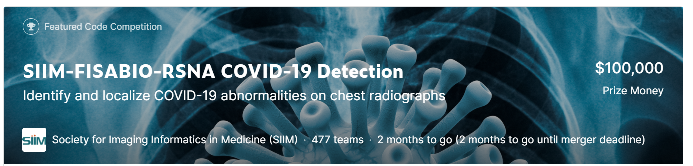

X線診断の基礎知識😷<br>
X線の吸収は、X線の波長、対象の厚さ、対象の密度、構成原子などによって定義されます。水に基づいて、心臓、大血管、および縦隔はに近いです。水の吸収、および肺胞はほとんど空気であるため、吸収されません。生体にX線を照射すると、吸収の違いにより、X線フィルムにそれぞれの黒さ（黒化度）が現れます。骨はX線を吸収して通過させないため、フィルムは人体で最も白く、肺には空気が多く含まれているため、肺野は比較的黒く見えます。肺が炎症を起こし、滲出液（水に近い透過性）が増加すると、それは白い影と見なすことができ、肺が崩壊して気胸のように肺組織が収縮すると、その部分は均一に黒くなります。映画に登場します。この黒ずみの程度の違い、つまりX線写真の影を通常の解剖学的構造と比較したり、病気による変化画像と見なしたりすることで、X線診断が発展します。

これはどうやって学習させればいいのわかりません。写真をたくさん載せていますが、どうすれば診断できるのか不明です。<br>
思い切って、グランドマスターに聞いてみました。<br>

答えは、あなたは医者じゃないんでしょ。じゃあ、モデルをつくるしかないよ、とのことでした。<br>

がんばって、色々しらべたのですが無駄になってしましました。<br>



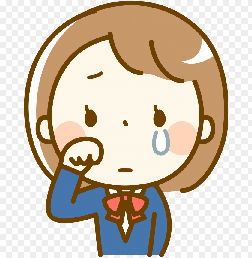
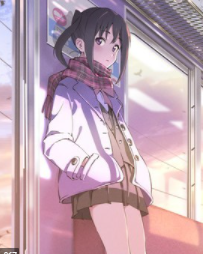

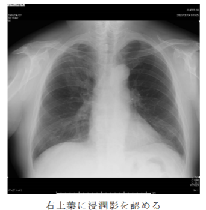

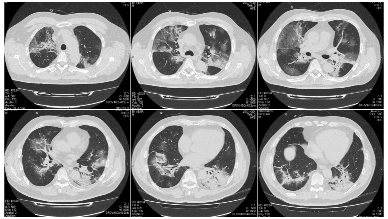

左右：すりガラスの不透明度が広範囲に散らばっており、紐のような影がいくつかあります。
右下葉に空気気管支造影による不規則な硬化が観察され、胸膜直下の病変は右下葉に顕著ではなく、肺炎様に組織化されていた。

In [ ]:
!conda install '../input/notebook66a8aacbe7/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -c conda-forge -y
!conda install '../input/notebook66a8aacbe7/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -c conda-forge -y
!conda install '../input/notebook66a8aacbe7/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -c conda-forge -y

!conda install '../input/notebook66a8aacbe7/conda-4.10.1-py37h89c1867_0.tar.bz2' -c conda-forge -y
!conda install '../input/notebook66a8aacbe7/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -c conda-forge -y
!conda install '../input/notebook66a8aacbe7/openssl-1.1.1k-h7f98852_0.tar.bz2' -c conda-forge -y

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
from fastai.vision.all import *
from fastai.medical.imaging import *
warnings.filterwarnings('ignore')
class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'

In [ ]:
dataset_path = Path('../input/siim-covid19-detection')

In [ ]:
train_study_df = pd.read_csv(dataset_path/'train_study_level.csv')

In [ ]:
study_classes = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
np.unique(train_study_df[study_classes].values, axis=0)

In [ ]:
train_image_df = pd.read_csv(dataset_path/'train_image_level.csv')

In [ ]:
train_image_df['split_label'] = train_image_df.label.apply(lambda x: [x.split()[offs:offs+6] for offs in range(0, len(x.split()), 6)])

In [ ]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='rainbow', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [ ]:
#dicom_paths = get_dicom_files(dataset_path/'train')
#imgs = [dicom2array(path) for path in dicom_paths[:4]]
#plot_imgs(imgs)

In [ ]:
#num_images_per_study = []
#for i in (dataset_path/'train').ls():
#    num_images_per_study.append(len(get_dicom_files(i)))
#    if len(get_dicom_files(i)) > 5:
#        print(f'Study {i} had {len(get_dicom_files(i))} images')
    

In [ ]:
def image_path(row):
    study_path = dataset_path/'train'/row.StudyInstanceUID
    for i in get_dicom_files(study_path):
        if row.id.split('_')[0] == i.stem: return i 
        
train_image_df['image_path'] = train_image_df.apply(image_path, axis=1)

# 📌random

In [ ]:
imgs = []
image_paths = train_image_df['image_path'].values
color_mean=(104,11,12)
# map label_id to specify color
thickness = 5
scale = 5


for i in range(8):
    image_path = random.choice(image_paths)
    img = dicom2array(path=image_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    

    img = np.stack([img, img, img], axis=-1)
    for i in train_image_df.loc[train_image_df['image_path'] == image_path].split_label.values[0]:
        if i[0] == 'opacity':
            
            img = cv2.rectangle(img,
                                (int(float(i[2])/scale), int(float(i[3])/scale)),
                                (int(float(i[4])/scale), int(float(i[5])/scale)),
                                [255,0,0], thickness)
    
    img = cv2.resize(img, (500,500))
    
    img = img - color_mean
    imgs.append(img)
    
plot_imgs(imgs, cmap="rainbow")

In [ ]:
def show_img(data):
  imgs=[]

  image_paths = train_image_df['image_path'].values

  # map label_id to specify color
  thickness = 5
  scale = 5


  for i in data:
    file = '../input/siim-covid19-detection/train/{}/*/*'.format(i)
    file = glob.glob(file)[0]
    img = dicom2array(path=file)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    for i in train_image_df.loc[train_image_df['image_path'] == image_path].split_label.values[0]:
        if i[0] == 'opacity':
            
            img = cv2.rectangle(img,
                                (int(float(i[2])/scale), int(float(i[3])/scale)),
                                (int(float(i[4])/scale), int(float(i[5])/scale)),
                                [255,0,0], thickness)
    
    img = cv2.resize(img, (500,500))
    img = img - color_mean
    imgs.append(img)
    
  plot_imgs(imgs, cmap="rainbow",img_size=None)

# 📌典型的な外観 Typical Appearance

まるで共通的なことがわかりません。

In [ ]:
data = ["72044bb44d41", "5b65a69885b6", "6aa32e76f998","71fb5ea71283","71f56b6a5589",
                         "c9ffe6312921", "082cafb03942", "d3e83031ebea"]
show_img(data)

# 📌非定型の外観 Atypical Appearance

In [ ]:
data = ["f807cd855d31", "8087e3bc0efe", "7249de10ed69","000c9c05fd14","0051d9b12e72",
                         "e300a4e86207", "4bac6c7da8b8", "f2d30ac37f7b"] 
show_img(data)

# 📌不確定な外観 Indeterminate Appearance

In [ ]:
data =["b949689a9ef1", "fe7e6015560d", "feffa20fac13","f871e115903e","f87baaa34bec",
                         "747483509d0e", "c70369caef91", "1e1b4b1b53cb"]
show_img(data)

# 📌肺炎は陰性 Negative for Pneumonia

In [ ]:
data = ["612ea5194007", "db14e640e037", "d4ab797396b4","612db6880c2d","60f2bf33d1b1",
                         "60c6d93dbf6b", "b3cf474bee3b", "0ba55e5422ab"]
show_img(data)

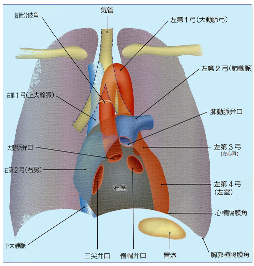

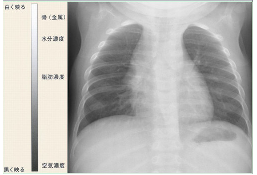

http://nagasawanorio.cocolog-nifty.com/blog/2013/03/x-dc23.html


# 結論、医者ではないので写真みてもわかりません